# Static modelling

<ul>
<li>Explore statistical correlation between different parameters</li>
<li>ML to get static condition</li>
<li>Deep learning to test $Head$ in terms of pump speed and  $head$</li>
</ul>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

In [ ]:
## load the file from local directory
#from google.colab import files
#uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive')

#drive.flush_and_unmount()
#print('All changes made in this colab session should now be visible in Drive.')


Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
#import io
#df = pd.read_csv(io.StringIO(uploaded['vattenfall_turbine.csv'].decode('utf-8')))

df = pd.read_csv('/content/drive/MyDrive/Data/vattenfall_turbine.csv')
keys = df.dtypes.index[1:11]
df_data = df[df.dtypes.index[1:10]]

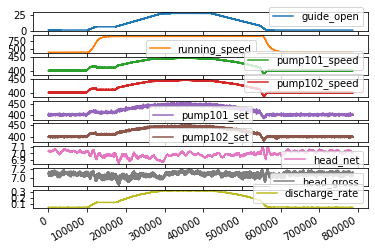

In [ ]:
df_data.plot(subplots=True)
#plt.tight_layout()
plt.show()

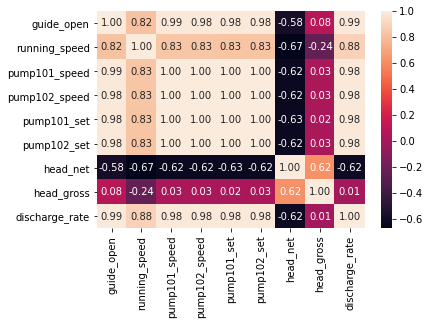

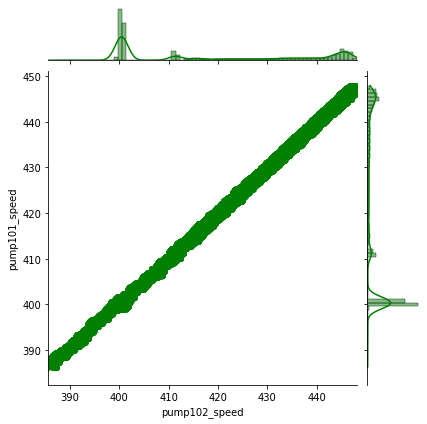

In [ ]:
#sns.lmplot(df.dtypes.index[1],df.dtypes.index[2], data=df, fit_reg=False)

sns.heatmap(df_data.corr(), annot=True, fmt=".2f")
plt.show()

sns.jointplot(data=df_data, x='pump102_speed', y='pump101_speed', kind='reg', color='g')
plt.show()

## 2, Use the RNN method to build the ML model (correlated time series)

In [ ]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
! /opt/bin/nvidia-smi

Tue Sep 14 11:13:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


In [ ]:
import itertools
from itertools import product  
import numpy as np
import xarray as xr
import pandas as pd
from copy import copy
from copy import deepcopy
import datetime
from time import time
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import math, random

In [ ]:
TIME_STEP = 10 # rnn 时序步长数
INPUT_SIZE = 1 # rnn 的输入维度
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
DEVICE = torch.device("cuda:0") 
H_SIZE = 64 # of rnn 隐藏单元个数
EPOCHS=300 # 总共训练次数
EPOCHS=300 # 总共训练次数
h_state = None # 隐藏层状态

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
        input_size=INPUT_SIZE,
        hidden_size=H_SIZE, 
        num_layers=1, 
        batch_first=True,
        )
        self.out = nn.Linear(H_SIZE, 1)
    def forward(self, x, h_state):
         # x (batch, time_step, input_size)
         # h_state (n_layers, batch, hidden_size)
         # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        #print(r_out.shape)
        outs = [] # 保存所有的预测值
        for time_step in range(r_out.size(1)): # 计算每一步长的预测值
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state
         # 也可使用以下这样的返回值
         # r_out = r_out.view(-1, 32)
         # outs = self.out(r_out)
         # return outs, h_state

In [ ]:
rnn = RNN().to(DEVICE)
optimizer = torch.optim.Adam(rnn.parameters()) # Adam优化，几乎不用调参
criterion = nn.MSELoss() # 因为最终的结果是一个数值，所以损失函数用均方误差

In [ ]:
torch.manual_seed(10010)
random.seed(10010)
np.random.seed(10010)
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
#    start, end = step * np.pi, (step+1)*np.pi # 一个时间周期
#    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
#    x_np = np.sin(steps) 
#    y_np = np.cos(steps)
#    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) # shape (batch, time_step, input_size)
#    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    #x_np = Features.values
    x_np = df_data.pump101_speed.values[:,np.newaxis]
    y_np = df_data.pump101_speed.values[:,np.newaxis]
    x_np = x_np[200000:200500,]
    y_np = y_np[200000:200500,]
    x_np = np.array(x_np, dtype = np.float32)
    y_np = np.array(y_np, dtype = np.float32)
    
    x = torch.from_numpy(x_np[np.newaxis, :, :]) # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, :])
    
    x=x.to(DEVICE)
    prediction, h_state = rnn(x, h_state) # rnn output
    #print(prediction.shape)
    # 这一步非常重要
    h_state = h_state.data # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction.cpu(), y) 
    # 这三行写在一起就可以
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if (step+1)%100==0: #每训练20个批次可视化一下效果，并打印一下loss
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(y_np.flatten(), 'r-')
        plt.plot(prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(1e-7)

KeyboardInterrupt: ignored

10

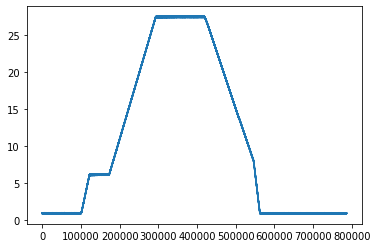

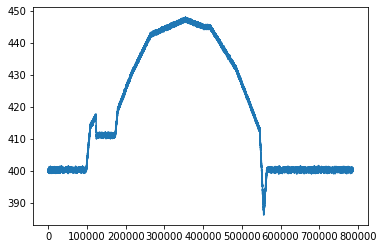

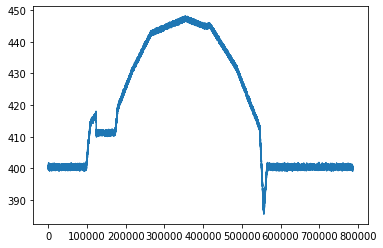

In [ ]:
plt.plot(df_data.guide_open)
plt.show()
plt.plot(df_data.pump101_speed)
plt.show()
plt.plot(df_data.pump102_speed)
plt.show()


EPOCHS: 19,Loss:0.065407


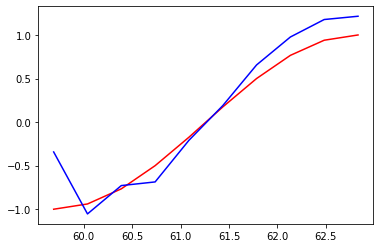

EPOCHS: 39,Loss:0.054160


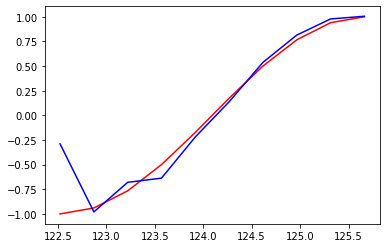

EPOCHS: 59,Loss:0.052042


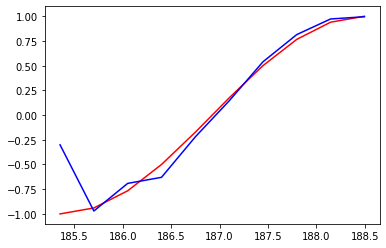

EPOCHS: 79,Loss:0.049947


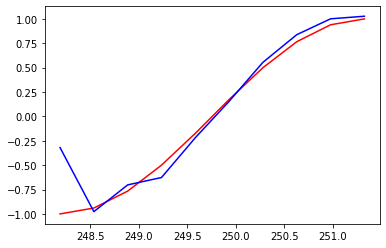

EPOCHS: 99,Loss:0.046264


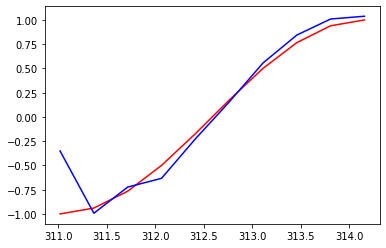

EPOCHS: 119,Loss:0.042869


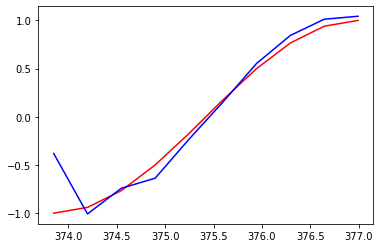

EPOCHS: 139,Loss:0.039421


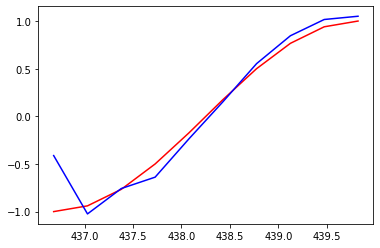

EPOCHS: 159,Loss:0.036280


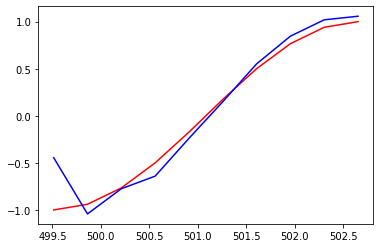

EPOCHS: 179,Loss:0.033471


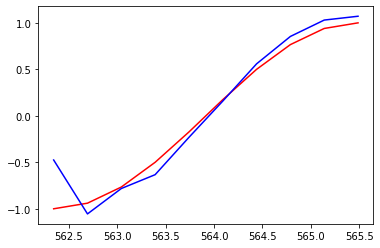

EPOCHS: 199,Loss:0.031238


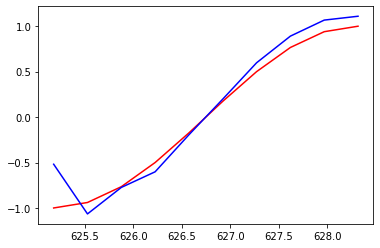

EPOCHS: 219,Loss:0.340514


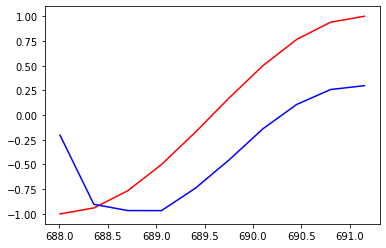

EPOCHS: 239,Loss:0.437077


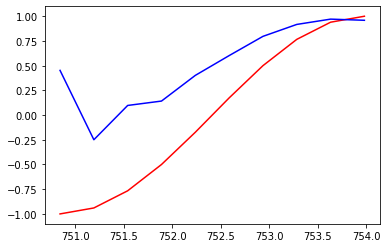

EPOCHS: 259,Loss:0.177472


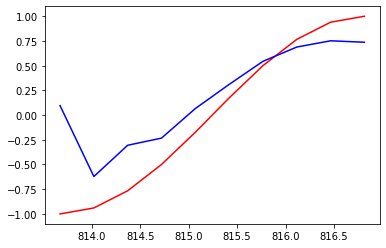

EPOCHS: 279,Loss:0.101393


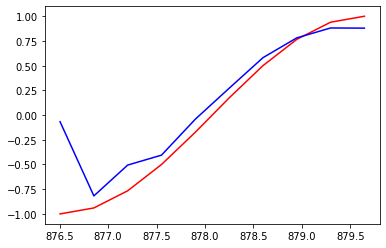

EPOCHS: 299,Loss:0.055096


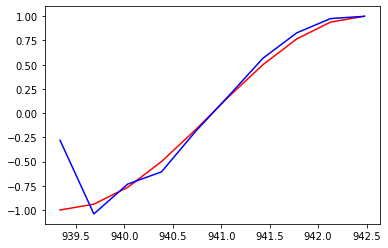

In [ ]:
torch.manual_seed(10010)
random.seed(10010)
np.random.seed(10010)
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
    start, end = step * np.pi, (step+1)*np.pi # 一个时间周期
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps) 
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    x=x.to(DEVICE)
    prediction, h_state = rnn(x, h_state) # rnn output
    #print(prediction.shape)
    # 这一步非常重要
    h_state = h_state.data # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction.cpu(), y) 
    # 这三行写在一起就可以
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if (step+1)%20==0: #每训练20个批次可视化一下效果，并打印一下loss
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(1e-7)

In [ ]:
import tensorflow as tf
